<a href="https://www.kaggle.com/code/babaksh/anime-face-image-gan-pytorch?scriptVersionId=243195707" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Anime Face Generator using GANs
A comprehensive implementation of a Generative Adversarial Network (GAN) 
to generate high-quality anime face images using PyTorch.

This notebook demonstrates the complete pipeline from data preprocessing 
to model training and evaluation on the Anime Face Dataset.

## Project Overview
This notebook implements a **Generative Adversarial Network (GAN)** to generate realistic anime face images. 
GANs consist of two neural networks competing against each other:

- **Generator**: Creates fake images from random noise
- **Discriminator**: Distinguishes between real and fake images

Through this adversarial training process, the generator learns to create increasingly realistic anime faces.

## Dataset
We'll be using the **Anime Face Dataset** containing 63,632 high-quality anime face images from Kaggle.


## Key Features
- Data preprocessing and augmentation
- Custom GAN architecture optimized for face generation
- Progressive training with visualization
- Real-time monitoring of generated samples
- Model checkpointing and evaluation metrics

Let's begin our journey into the world of AI-generated anime art! 🚀


## Import Required Libraries

We'll start by importing all necessary libraries for our GAN implementation:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
# Configuration
IMG_SIZE = 64
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EPOCHS = 20
NOISE_DIM = 100
num_examples_to_generate = 16
LEARNING_RATE = 0.0002
GENERATOR_LR = 0.00005
DISCRIMINATOR_LR = 0.00002

In [4]:
# Configure device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

print(f"PyTorch Version: {torch.__version__}")
# Keras version is not relevant here.

Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
PyTorch Version: 2.6.0+cu124


## Dataset Exploration and Analysis

Let's explore our anime face dataset to understand its structure and characteristics.
This analysis will help us make informed decisions about preprocessing and model architecture.


In [5]:
# Dataset path (Kaggle environment)
DATASET_PATH = "/kaggle/input/animefacedataset"
if not os.path.exists(DATASET_PATH):
    DATASET_PATH = "/kaggle/input/animefacedataset/images"
if not os.path.exists(DATASET_PATH):
    DATASET_PATH = "/kaggle/input/animefacedataset/data"

In [6]:
# Find the correct path
for root, dirs, files in os.walk("/kaggle/input/animefacedataset"):
    if len(files) > 1000:  # Assuming we have many image files
        DATASET_PATH = root
        break

print(f"Dataset path: {DATASET_PATH}")

Dataset path: /kaggle/input/animefacedataset/images


In [7]:
# Get list of image files
image_files = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for file in os.listdir(DATASET_PATH):
    if file.lower().endswith(valid_extensions):
        image_files.append(file)

print(f"Total number of images: {len(image_files)}")
print(f"Sample filenames: {image_files[:5]}")

Total number of images: 63565
Sample filenames: ['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg']


## Dataset Visualization

Let's visualize some sample images from our dataset to understand the variety and quality of anime faces we're working with.


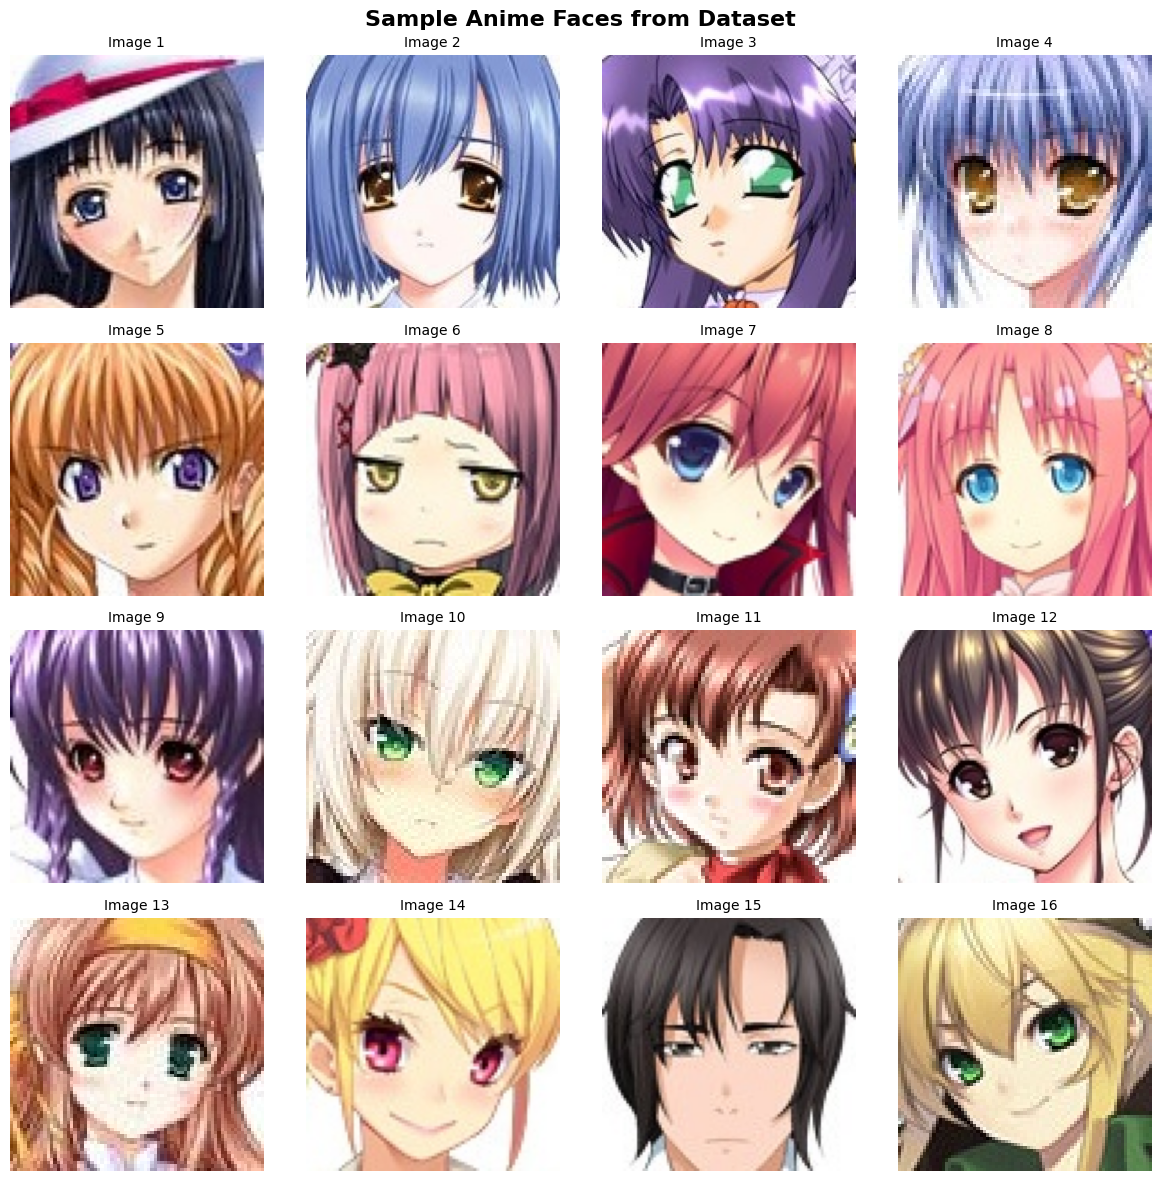

In [8]:
def display_sample_images(image_files, dataset_path, num_samples=16):
    """Display a grid of sample images from the dataset"""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Sample Anime Faces from Dataset', fontsize=16, fontweight='bold')
    
    sample_files = np.random.choice(image_files, num_samples, replace=False)
    
    for i, ax in enumerate(axes.flat):
        if i < len(sample_files):
            img_path = os.path.join(dataset_path, sample_files[i])
            try:
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(f'Image {i+1}', fontsize=10)
            except Exception as e:
                ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(image_files, DATASET_PATH)

## Image Properties Analysis

Let's analyze the dimensions, color distribution, and other properties of our images to inform our preprocessing pipeline.


In [9]:
def analyze_images(image_files, dataset_path, sample_size=1000):
    """Analyze image properties from a sample of the dataset"""
    sample_files = np.random.choice(image_files, min(sample_size, len(image_files)), replace=False)
    
    widths, heights, channels = [], [], []
    file_sizes = []
    
    print("Analyzing image properties...")
    for filename in tqdm(sample_files[:100]):  # Analyze first 100 for speed
        try:
            img_path = os.path.join(dataset_path, filename)
            img = Image.open(img_path)
            width, height = img.size
            
            widths.append(width)
            heights.append(height)
            channels.append(len(img.getbands()))
            file_sizes.append(os.path.getsize(img_path))
            
        except Exception as e:
            continue
    
    return {
        'widths': widths,
        'heights': heights,
        'channels': channels,
        'file_sizes': file_sizes
    }

Analyzing image properties...


100%|██████████| 100/100 [00:00<00:00, 150.87it/s]


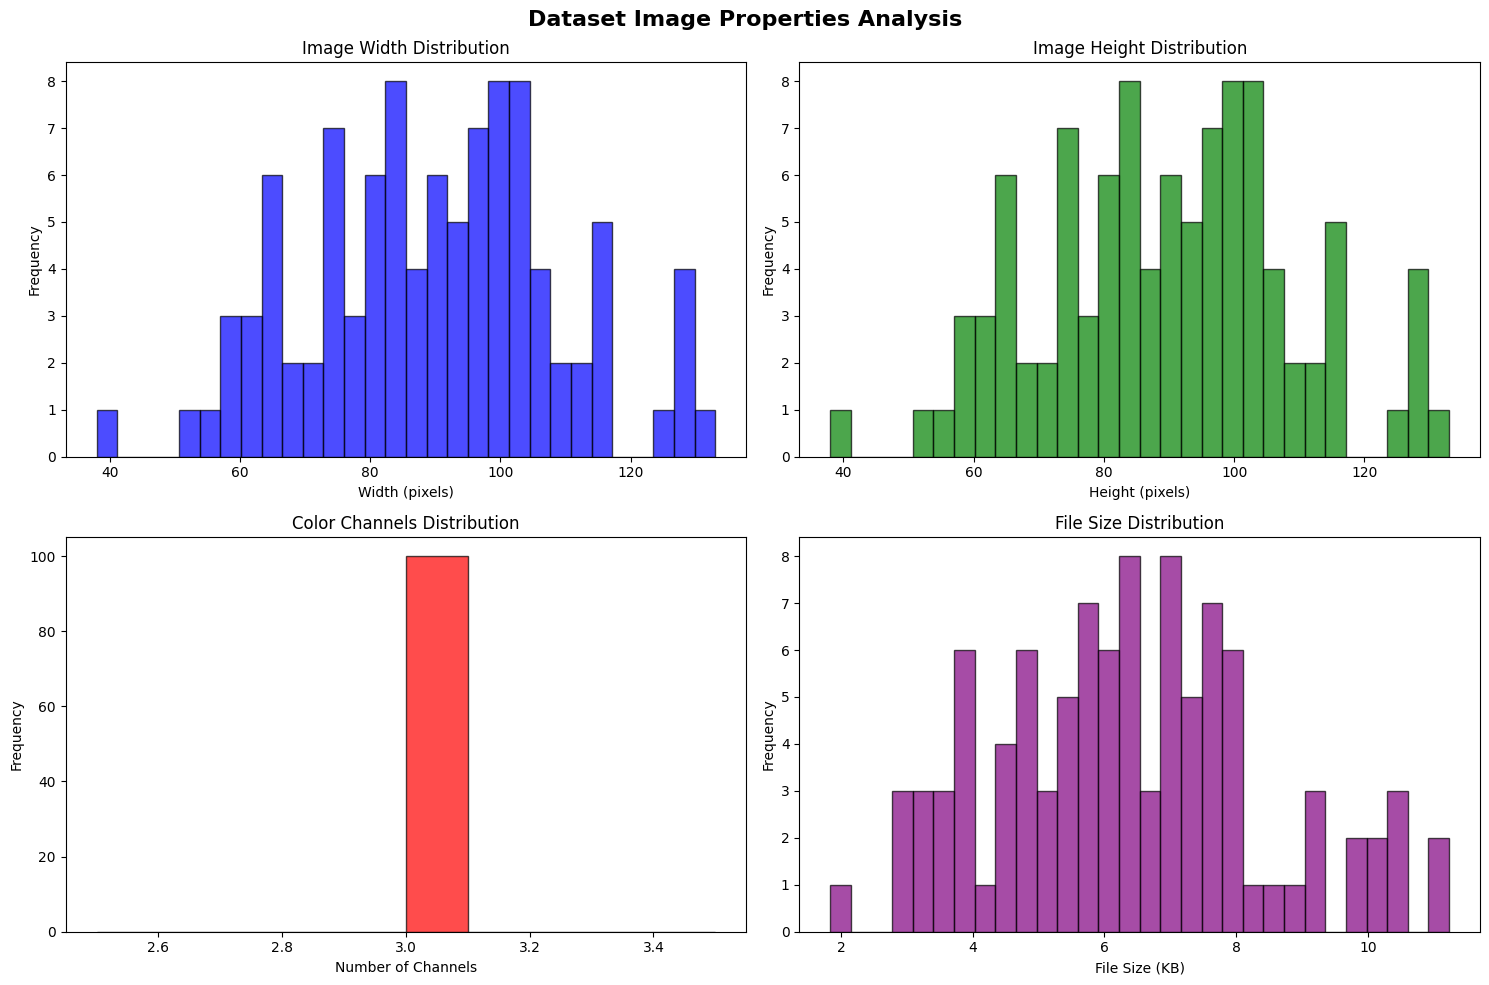

In [10]:
# Analyze images
image_stats = analyze_images(image_files, DATASET_PATH)

# Create visualization of image properties
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Image Properties Analysis', fontsize=16, fontweight='bold')

# Width distribution
axes[0, 0].hist(image_stats['widths'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Image Width Distribution')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')

# Height distribution
axes[0, 1].hist(image_stats['heights'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Image Height Distribution')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')

# Channels distribution
axes[1, 0].hist(image_stats['channels'], bins=10, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('Color Channels Distribution')
axes[1, 0].set_xlabel('Number of Channels')
axes[1, 0].set_ylabel('Frequency')

# File sizes distribution
axes[1, 1].hist([size/1024 for size in image_stats['file_sizes']], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('File Size Distribution')
axes[1, 1].set_xlabel('File Size (KB)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Print statistics
print(f"Image Statistics:")
print(f"Average Width: {np.mean(image_stats['widths']):.1f} ± {np.std(image_stats['widths']):.1f}")
print(f"Average Height: {np.mean(image_stats['heights']):.1f} ± {np.std(image_stats['heights']):.1f}")
print(f"Most common channels: {max(set(image_stats['channels']), key=image_stats['channels'].count)}")
print(f"Average file size: {np.mean(image_stats['file_sizes'])/1024:.1f} KB")


Image Statistics:
Average Width: 89.3 ± 19.2
Average Height: 89.3 ± 19.2
Most common channels: 3
Average file size: 6.4 KB


## Data Preprocessing Pipeline

Now we'll create a robust preprocessing pipeline to prepare our images for GAN training:

1. **Resize** images to a consistent size (64x64 pixels)
2. **Normalize** pixel values to [-1, 1] range
3. **Create batches** for efficient training
4. **Apply data augmentation** to increase dataset diversity



In [12]:
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Converts to [0, 1] and C, H, W
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizes to [-1, 1]
])

In [13]:
class AnimeDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Error: {e}. Returning zero tensor.")
            return torch.zeros((3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)


In [14]:
image_paths = [os.path.join(DATASET_PATH, f) for f in image_files]

# Create the dataset instance
anime_dataset = AnimeDataset(image_paths, transform=img_transforms)
print(f"Dataset created successfully!")

train_dataloader = DataLoader(anime_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4,
                              drop_last=True,
                              pin_memory=True) # num_workers for parallel loading

dataset_size = len(anime_dataset)
print(f"Total training samples: {dataset_size}")
print(f"Batches per epoch: {len(train_dataloader)}")
print(f"Image shape: {(3, IMG_SIZE, IMG_SIZE)}")
print(f"Batch size: {BATCH_SIZE}")

Dataset created successfully!
Total training samples: 63565
Batches per epoch: 993
Image shape: (3, 64, 64)
Batch size: 64


## Visualizing Preprocessed Data

Let's verify our preprocessing pipeline by visualizing some processed images to ensure they look correct.

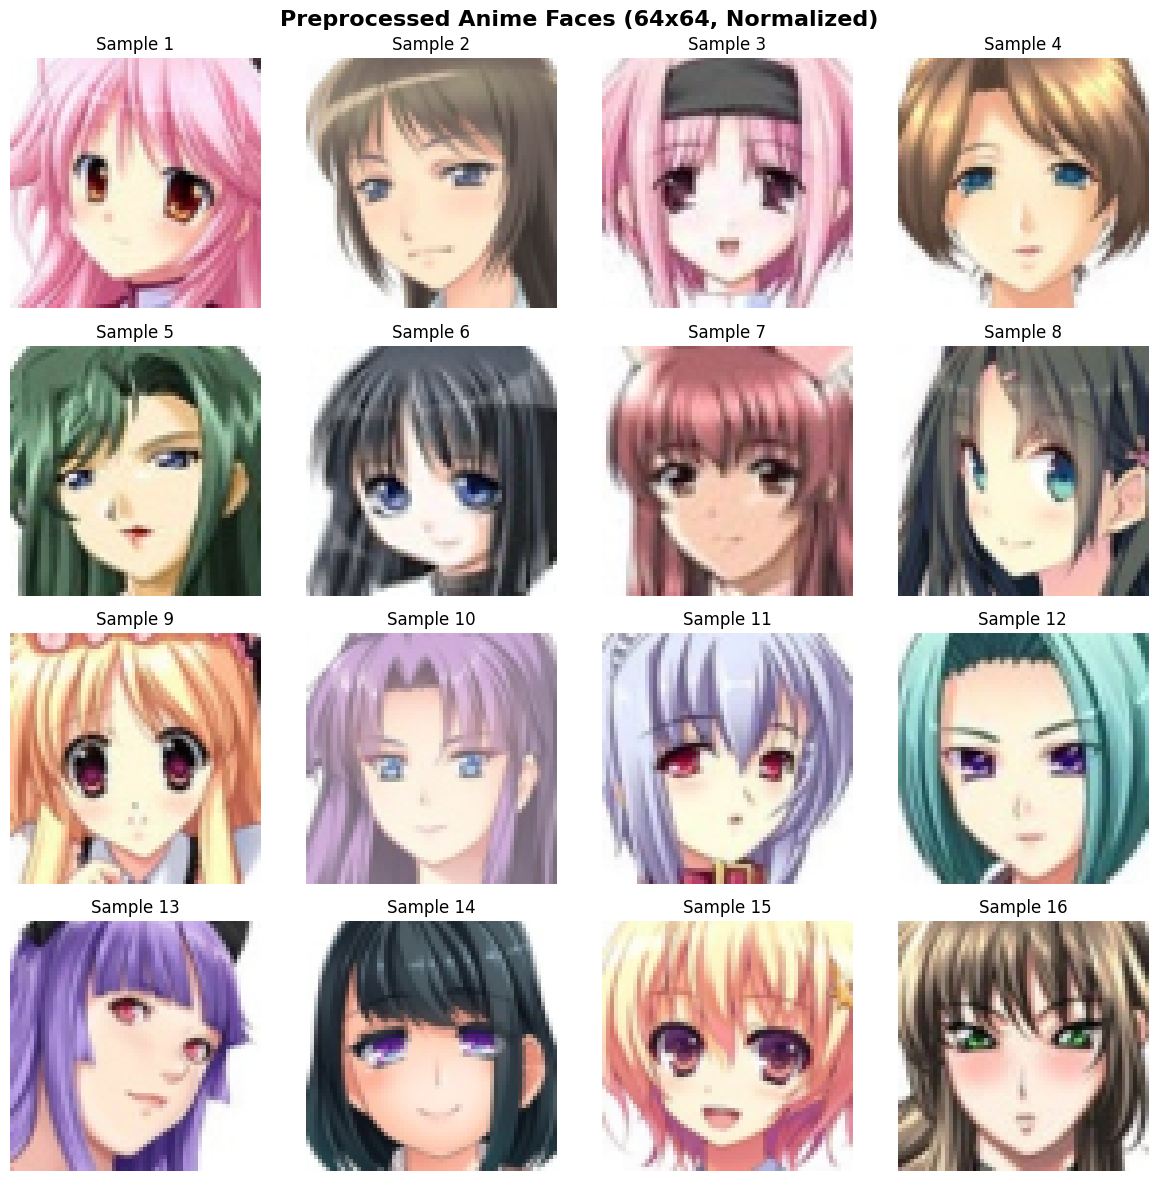

In [15]:
def show_preprocessed_batch(dataloader, num_images=16):
    """Display a batch of preprocessed images"""
    # Get one batch from the dataloader
    batch = next(iter(dataloader))
    batch = batch.to(device if device.type != 'mps' else 'cpu')
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Preprocessed Anime Faces (64x64, Normalized)', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < num_images and i < batch.size(0):
            # Denormalize for display
            img = batch[i] * 0.5 + 0.5  # From [-1, 1] to [0, 1]
            img = torch.clamp(img, 0.0, 1.0)
            ax.imshow(img.cpu().permute(1, 2, 0).numpy())
            ax.set_title(f'Sample {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_preprocessed_batch(train_dataloader)

## GAN Architecture: Generator Network

The Generator network transforms random noise into realistic anime faces. Our architecture uses:

- **Transpose Convolutions** for upsampling
- **Batch Normalization** for stable training
- **ReLU** activations for better gradient flow
- **Progressive upsampling** from 4x4 to 64x64

The generator starts with a 100-dimensional noise vector and progressively upsamples to create 64x64x3 images.


In [16]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        
        self.main = nn.Sequential(
            # Project and reshape
            nn.Linear(noise_dim, 4 * 4 * 1024, bias=False),
            nn.BatchNorm1d(4 * 4 * 1024), # Applied on the linear layer output before reshape
            nn.ReLU(True),
            # Reshape handled in forward pass: x.view(-1, 1024, 4, 4)

            # Upsample to 8x8
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # out: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Upsample to 16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), # out: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Upsample to 32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # out: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Final layer: 64x64
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False), # out: 3 x 64 x 64
            nn.Tanh() # Output images in [-1, 1]
        )
        
        self.fc_part = self.main[0:3] # Dense, BN1d, ReLU
        self.conv_part = self.main[3:] # All ConvTranspose and subsequent layers

    def forward(self, noise):
        x = self.fc_part(noise)
        x = x.view(-1, 1024, 4, 4) # Reshape to (batch_size, 1024, 4, 4)
        return self.conv_part(x)

In [17]:
generator = Generator(NOISE_DIM).to(device)

# Display model architecture
print("Generator Architecture:")
print(generator) # This prints the layer structure

# Test generator with random noise
noise = torch.randn(1, NOISE_DIM, device=device)
generator.eval() 

with torch.no_grad(): 
    generated_image = generator(noise)
    
generator.train()
print(f"Generated image shape: {generated_image.shape}")

Generator Architecture:
Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=False)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): 

## GAN Architecture: Discriminator Network

The Discriminator acts as a binary classifier, distinguishing real anime faces from generated ones. Key features:

- **Convolutional layers** for feature extraction
- **Leaky ReLU** activations to prevent dying neurons
- **Dropout** for regularization
- **Batch normalization** is used in most layers to help stabilize training
- **Binary output** (real vs fake probability)


In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input: 3 x 64 x 64
        self.main = nn.Sequential(
            # Layer 1: 64 -> 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # out: 64 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Layer 2: 32 -> 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # out: 128 x 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Layer 3: 16 -> 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # out: 256 x 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Layer 4: 8 -> 4
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # out: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Final layer
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )

    def forward(self, img):
        x = self.main(img)
        return x.view(-1, 1) # Flatten to (batch_size, 1) for the loss function


In [19]:
discriminator = Discriminator().to(device)

# Display model architecture
print("Discriminator Architecture:")
print(discriminator)

# Test discriminator
discriminator.eval()
with torch.no_grad():
    decision = discriminator(generated_image) 
discriminator.train()

print(f"Discriminator decision shape: {decision.shape}")
print(f"Decision (logits): {decision.cpu().numpy()}") 

Discriminator Architecture:
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope

## Loss Functions and Optimizers

We'll use Binary Cross-Entropy loss for both networks:

- **Generator Loss**: Wants discriminator to classify fake images as real
- **Discriminator Loss**: Wants to correctly classify real vs fake images

We use separate Adam optimizers with different learning rates for stability.


In [20]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Labels for real and fake images
real_label_val = 1.0
fake_label_val = 0.0
label_smoothing = 0.1 

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=GENERATOR_LR, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LR, betas=(0.5, 0.999))

print("Loss function and optimizers configured!")
print(f"Criterion: {criterion.__class__.__name__}")
print(f"Generator optimizer: {optimizer_G.__class__.__name__}")
print(f"Discriminator optimizer: {optimizer_D.__class__.__name__}")

Loss function and optimizers configured!
Criterion: BCEWithLogitsLoss
Generator optimizer: Adam
Discriminator optimizer: Adam


## Training Setup and Checkpoints

We'll set up checkpointing to save our model progress and enable resuming training if needed.


In [21]:
# Checkpoint setup
checkpoint_dir = './training_checkpoints_pytorch'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [22]:
# Create fixed noise for consistent visualization
fixed_noise = torch.randn(num_examples_to_generate, NOISE_DIM, device=device)

print("Training setup complete!")
print(f"Checkpoint directory: {checkpoint_dir}")

Training setup complete!
Checkpoint directory: ./training_checkpoints_pytorch


## Training Functions

Here we define the core training functions that will be executed for each batch:

1. **train_step**: Performs one training iteration
2. **generate_and_save_images**: Creates and displays generated samples
3. **Training loop**: Orchestrates the entire training process


In [23]:
def generate_and_save_images(model_G, epoch, test_input_noise): 
    """Generate and display images during training"""
    model_G.eval()
    with torch.no_grad(): 
        predictions = model_G(test_input_noise).cpu() 
    model_G.train() 
    
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions[i] * 0.5 + 0.5 # Denormalize from [-1, 1] to [0, 1]
        img = torch.clamp(img, 0.0, 1.0)
        
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Main Training Loop

Now we'll start the main training process! The GAN will train for the specified number of epochs, 
and we'll visualize the progress by generating sample images at regular intervals.

**What to expect:**
- Initial images will look like noise
- Gradually, face-like structures will emerge
- After several epochs, we should see recognizable anime faces
- Training time depends on the hardware (GPU recommended)

In [24]:
def train_gan(dataloader, generator, discriminator, optimizer_G, optimizer_D, criterion, epochs, noise_dim, fixed_noise, device, checkpoint_dir):
    gen_losses_history = []
    disc_losses_history = []
    
    print("Starting GAN training (PyTorch)...")
    print("=" * 50)

    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for i, real_images_batch in enumerate(progress_bar):
            real_images_batch = real_images_batch.to(device)
            current_batch_size = real_images_batch.size(0) 

            # --- Train Discriminator ---
            discriminator.zero_grad()
            # Real batch
            real_labels = torch.full((current_batch_size,), real_label_val - label_smoothing, dtype=torch.float, device=device)
            output_real = discriminator(real_images_batch).view(-1)
            errD_real = criterion(output_real, real_labels)

            # Fake batch
            noise = torch.randn(current_batch_size, noise_dim, device=device)
            fake_images = generator(noise)
            fake_labels = torch.full((current_batch_size,), fake_label_val, dtype=torch.float, device=device)
            output_fake = discriminator(fake_images.detach()).view(-1)
            errD_fake = criterion(output_fake, fake_labels)
            
            errD = errD_real + errD_fake
            errD.backward() 
            optimizer_D.step()
            
            # --- Train Generator ---
            generator.zero_grad()
            real_labels_for_G = torch.full((current_batch_size,), real_label_val, dtype=torch.float, device=device)
            output_fake_for_G = discriminator(fake_images).view(-1) 
            errG = criterion(output_fake_for_G, real_labels_for_G)
            errG.backward()
            optimizer_G.step()

            epoch_gen_loss.append(errG.item())
            epoch_disc_loss.append(errD.item()) 
            
            progress_bar.set_postfix({
                'Gen Loss': f'{errG.item():.4f}',
                'Disc Loss': f'{errD.item():.4f}'
            })

        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        gen_losses_history.append(avg_gen_loss)
        disc_losses_history.append(avg_disc_loss)
        
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, fixed_noise) 
            
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'gen_losses': gen_losses_history,
                'disc_losses': disc_losses_history,
            }, os.path.join(checkpoint_dir, f"ckpt_epoch_{epoch+1}.pth"))
            print(f'Checkpoint saved at epoch {epoch + 1}')
        
        print(f'Epoch {epoch + 1}: Gen Loss = {avg_gen_loss:.4f}, Disc Loss = {avg_disc_loss:.4f}')
        print("-" * 50)
        
    return gen_losses_history, disc_losses_history


Starting Anime Face GAN Training (PyTorch)!
Training with 63565 images for 20 epochs using PyTorch.
Grab some coffee ☕ - this might take a while!
Starting GAN training (PyTorch)...


Epoch 1/20: 100%|██████████| 993/993 [01:45<00:00,  9.42it/s, Gen Loss=1.4118, Disc Loss=1.2530]


Epoch 1: Gen Loss = 1.3059, Disc Loss = 1.2234
--------------------------------------------------


Epoch 2/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.2487, Disc Loss=1.3633]


Epoch 2: Gen Loss = 1.1484, Disc Loss = 1.2670
--------------------------------------------------


Epoch 3/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.1128, Disc Loss=1.3122]


Epoch 3: Gen Loss = 1.0416, Disc Loss = 1.3056
--------------------------------------------------


Epoch 4/20: 100%|██████████| 993/993 [01:18<00:00, 12.57it/s, Gen Loss=0.8553, Disc Loss=1.2523]


Epoch 4: Gen Loss = 0.9724, Disc Loss = 1.3197
--------------------------------------------------


Epoch 5/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=0.9190, Disc Loss=1.2968]


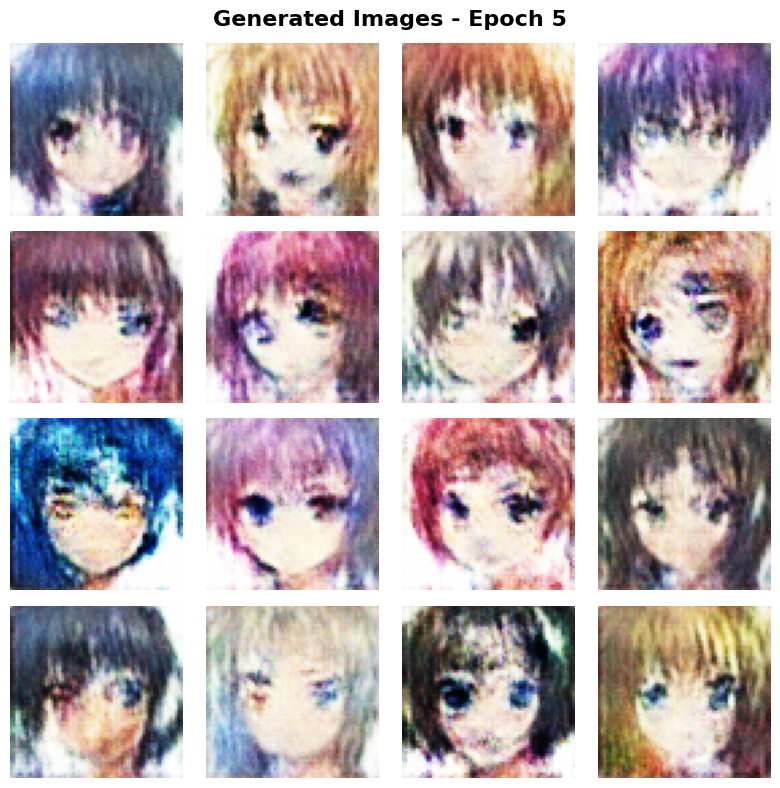

Epoch 5: Gen Loss = 0.9346, Disc Loss = 1.3226
--------------------------------------------------


Epoch 6/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.0639, Disc Loss=1.2998]


Epoch 6: Gen Loss = 1.0270, Disc Loss = 1.2717
--------------------------------------------------


Epoch 7/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.0352, Disc Loss=1.2341]


Epoch 7: Gen Loss = 1.0063, Disc Loss = 1.2855
--------------------------------------------------


Epoch 8/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.0043, Disc Loss=1.3057]


Epoch 8: Gen Loss = 0.9976, Disc Loss = 1.2827
--------------------------------------------------


Epoch 9/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.0992, Disc Loss=1.3561]


Epoch 9: Gen Loss = 1.0036, Disc Loss = 1.2673
--------------------------------------------------


Epoch 10/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=0.9798, Disc Loss=1.3074]


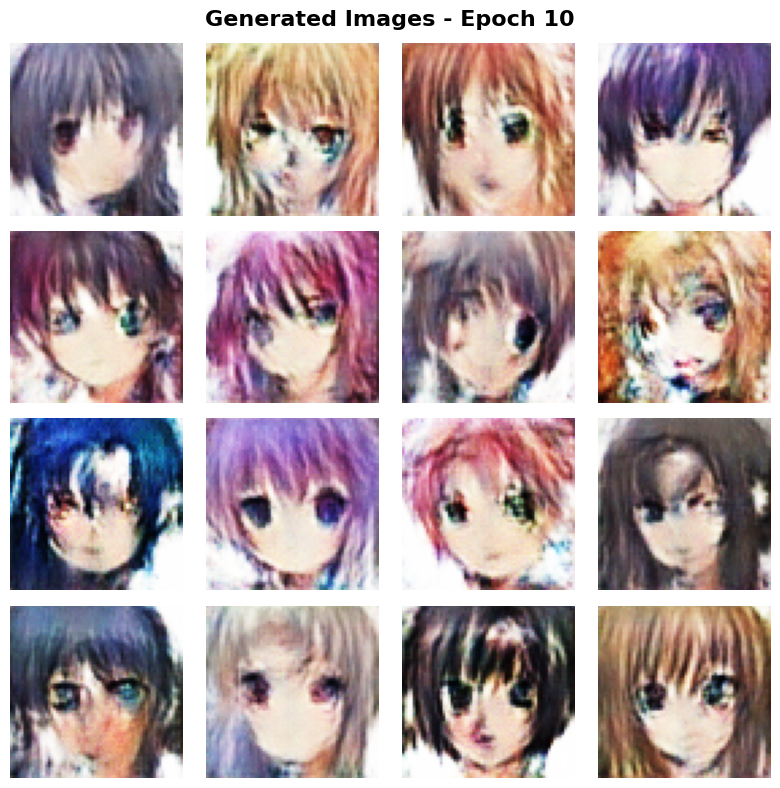

Checkpoint saved at epoch 10
Epoch 10: Gen Loss = 1.0182, Disc Loss = 1.2509
--------------------------------------------------


Epoch 11/20: 100%|██████████| 993/993 [01:18<00:00, 12.58it/s, Gen Loss=1.0861, Disc Loss=1.2446]


Epoch 11: Gen Loss = 1.0415, Disc Loss = 1.2391
--------------------------------------------------


Epoch 12/20: 100%|██████████| 993/993 [01:18<00:00, 12.62it/s, Gen Loss=1.0484, Disc Loss=1.2080]


Epoch 12: Gen Loss = 1.0606, Disc Loss = 1.2212
--------------------------------------------------


Epoch 13/20: 100%|██████████| 993/993 [01:18<00:00, 12.66it/s, Gen Loss=0.9452, Disc Loss=1.1292]


Epoch 13: Gen Loss = 1.0846, Disc Loss = 1.2037
--------------------------------------------------


Epoch 14/20: 100%|██████████| 993/993 [01:18<00:00, 12.61it/s, Gen Loss=1.2249, Disc Loss=1.0476]


Epoch 14: Gen Loss = 1.1081, Disc Loss = 1.1848
--------------------------------------------------


Epoch 15/20: 100%|██████████| 993/993 [01:18<00:00, 12.59it/s, Gen Loss=1.0264, Disc Loss=1.0913]


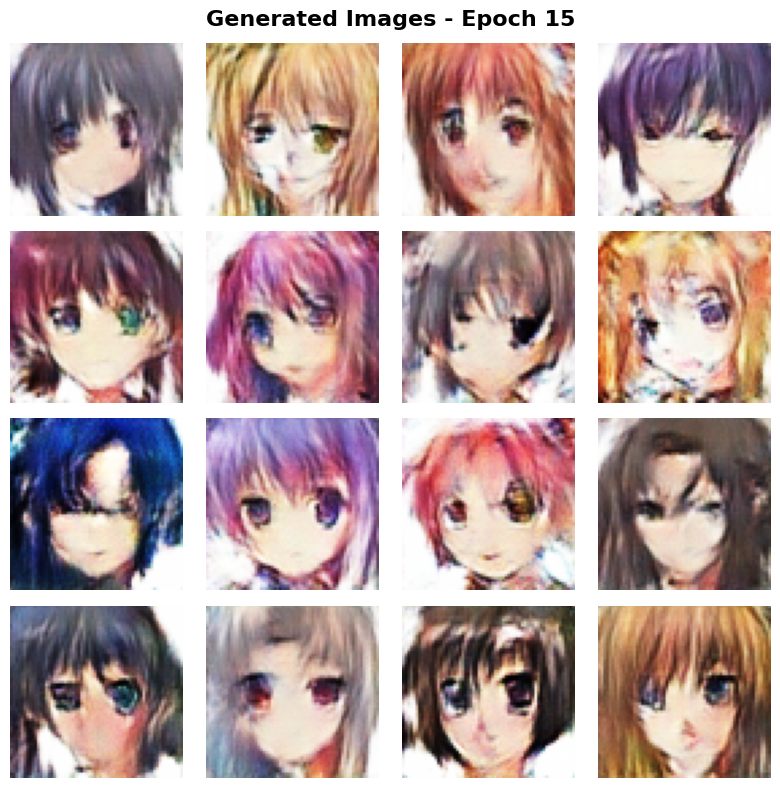

Epoch 15: Gen Loss = 1.1312, Disc Loss = 1.1669
--------------------------------------------------


Epoch 16/20: 100%|██████████| 993/993 [01:18<00:00, 12.59it/s, Gen Loss=1.1122, Disc Loss=1.0630]


Epoch 16: Gen Loss = 1.1624, Disc Loss = 1.1492
--------------------------------------------------


Epoch 17/20: 100%|██████████| 993/993 [01:18<00:00, 12.59it/s, Gen Loss=1.3028, Disc Loss=1.1601]


Epoch 17: Gen Loss = 1.1946, Disc Loss = 1.1327
--------------------------------------------------


Epoch 18/20: 100%|██████████| 993/993 [01:18<00:00, 12.60it/s, Gen Loss=1.2128, Disc Loss=1.0480]


Epoch 18: Gen Loss = 1.2199, Disc Loss = 1.1087
--------------------------------------------------


Epoch 19/20: 100%|██████████| 993/993 [01:18<00:00, 12.66it/s, Gen Loss=1.4768, Disc Loss=1.1146]


Epoch 19: Gen Loss = 1.2593, Disc Loss = 1.0926
--------------------------------------------------


Epoch 20/20: 100%|██████████| 993/993 [01:18<00:00, 12.66it/s, Gen Loss=1.3507, Disc Loss=1.0422]


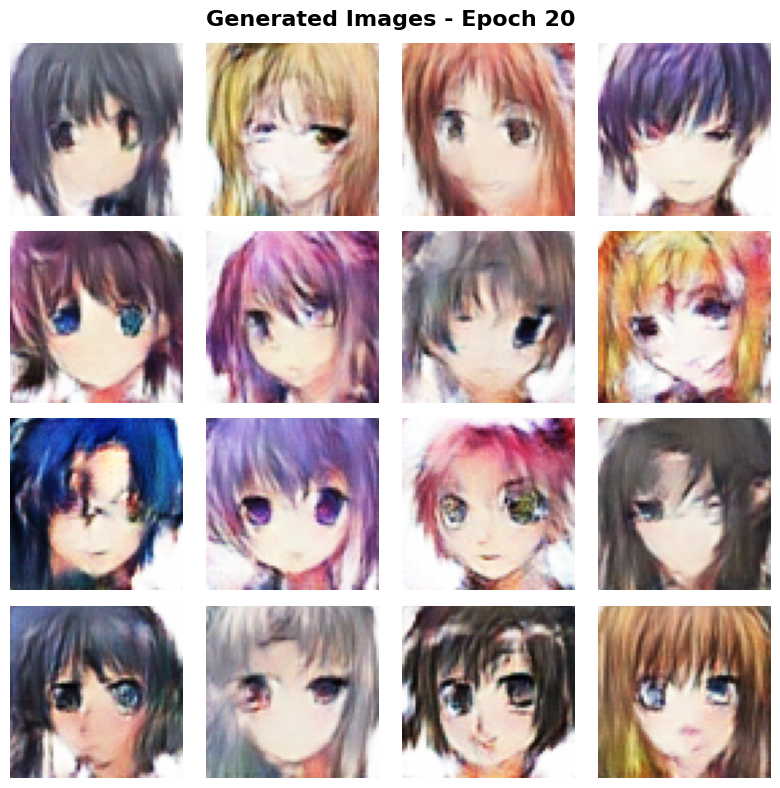

Checkpoint saved at epoch 20
Epoch 20: Gen Loss = 1.2817, Disc Loss = 1.0738
--------------------------------------------------
Training completed!


In [25]:
print("Starting Anime Face GAN Training (PyTorch)!")
print(f"Training with {len(anime_dataset)} images for {EPOCHS} epochs using PyTorch.")
print("Grab some coffee ☕ - this might take a while!")

gen_losses, disc_losses = train_gan(
    train_dataloader, generator, discriminator,
    optimizer_G, optimizer_D, criterion,
    EPOCHS, NOISE_DIM, fixed_noise, device, checkpoint_dir
)

print("Training completed!")

## Training Results Analysis

Let's analyze how our GAN performed during training by examining the loss curves and generating final samples.


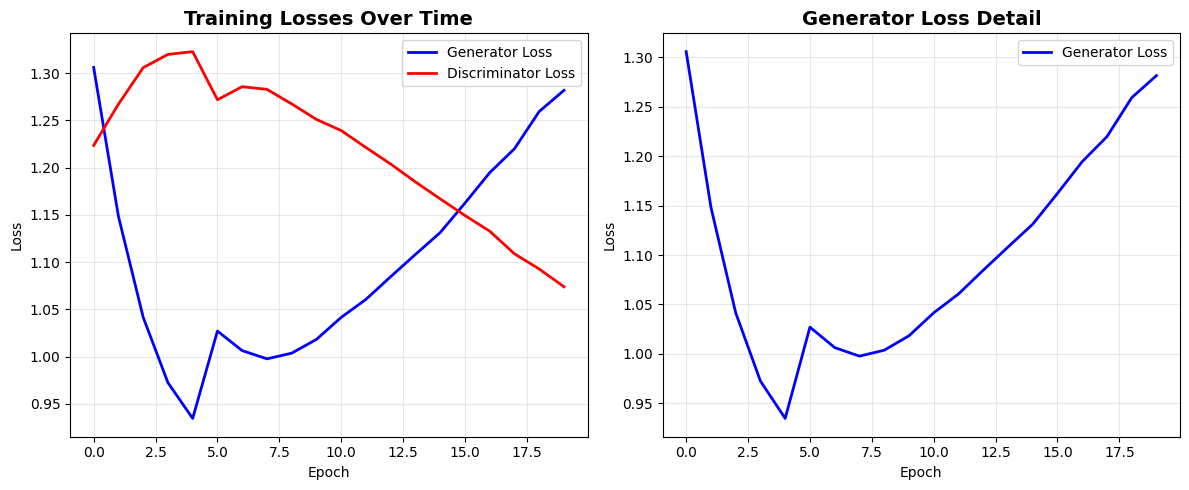

In [26]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gen_losses, label='Generator Loss', color='blue', linewidth=2)
plt.plot(disc_losses, label='Discriminator Loss', color='red', linewidth=2)
plt.title('Training Losses Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gen_losses, label='Generator Loss', color='blue', linewidth=2)
plt.title('Generator Loss Detail', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Print final statistics
print("Training Statistics:")
print(f"Final Generator Loss: {gen_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {disc_losses[-1]:.4f}")
print(f"Lowest Generator Loss: {min(gen_losses):.4f} (Epoch {np.argmin(gen_losses) + 1})")


Training Statistics:
Final Generator Loss: 1.2817
Final Discriminator Loss: 1.0738
Lowest Generator Loss: 0.9346 (Epoch 5)


## Final Results: Generated Anime Faces

Let's generate a final batch of anime faces using our trained generator and compare them with real images from our dataset.


Generating final anime faces (PyTorch)...


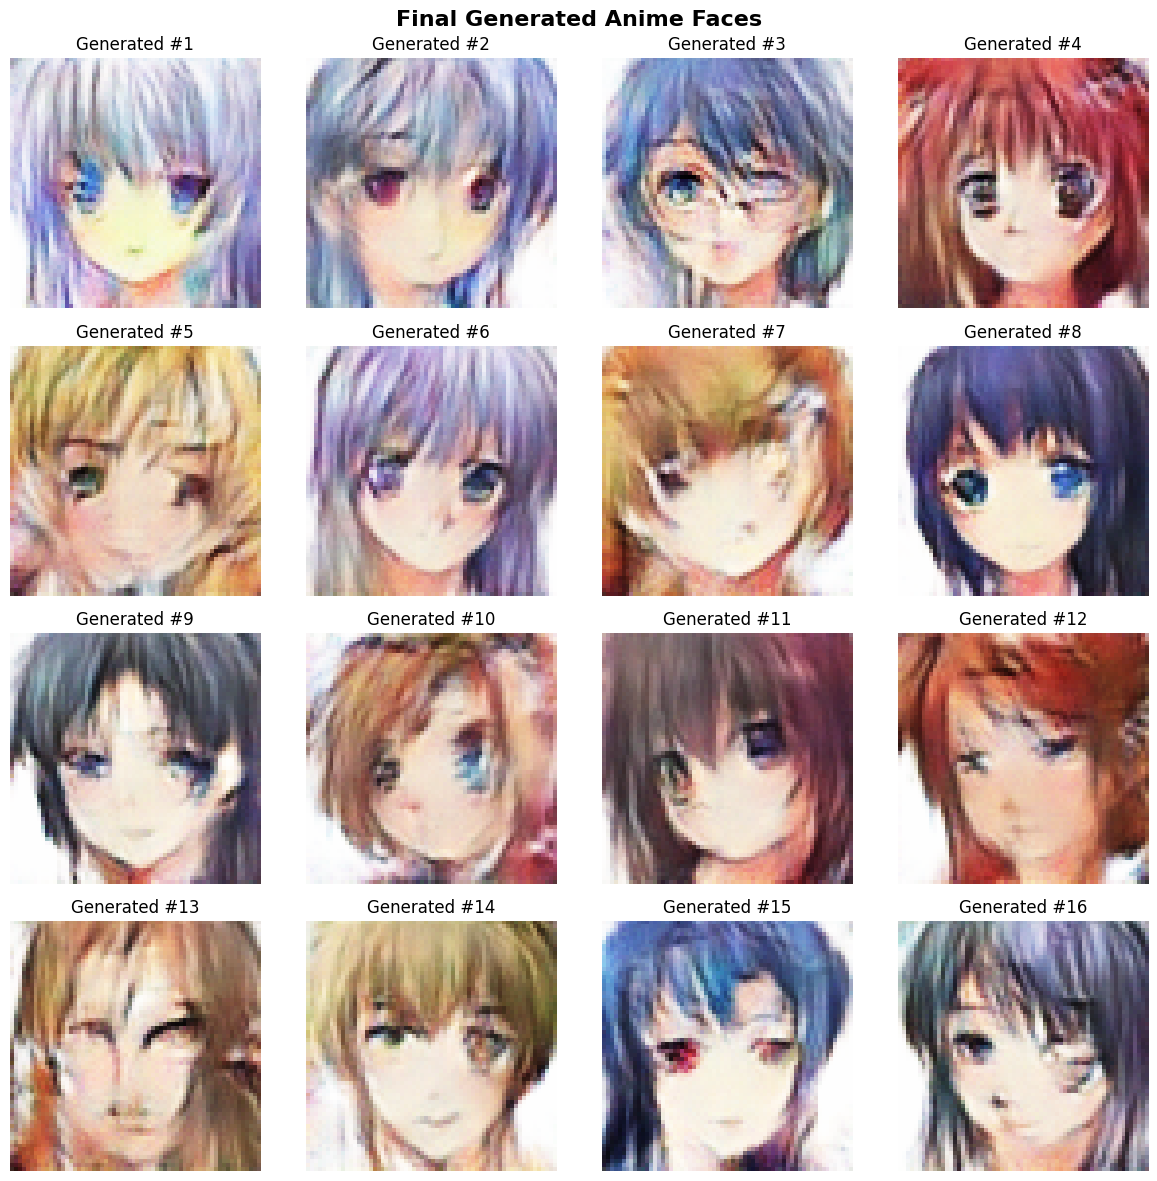

In [28]:
# Generate final images with the trained model
print("Generating final anime faces (PyTorch)...")

final_seed = torch.randn(16, NOISE_DIM, device=device) 
generator.eval() 
with torch.no_grad():
    final_generated_images = generator(final_seed).cpu() 
generator.train() 

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Final Generated Anime Faces', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    img = final_generated_images[i] * 0.5 + 0.5 # Denormalize
    img = torch.clamp(img, 0.0, 1.0)
    ax.imshow(img.permute(1, 2, 0).numpy()) # C,H,W to H,W,C
    ax.set_title(f'Generated #{i+1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Model Evaluation: Real vs Generated Comparison

Let's create a side-by-side comparison between real anime faces from our dataset and generated ones to evaluate the quality of our GAN.


In [29]:
def compare_real_vs_generated(dataloader, model_G, num_comparisons=8):
    """Compare real and generated images side by side"""
    # Get real images
    real_batch = next(iter(dataloader))
    real_images = real_batch[:num_comparisons].to(device if device.type != 'mps' else 'cpu')

    # Generate fake images
    noise = torch.randn(num_comparisons, NOISE_DIM, device=device)
    model_G.eval()
    with torch.no_grad():
        generated_images = model_G(noise).cpu() # Generate and move to CPU
    model_G.train()
    
    fig, axes = plt.subplots(2, num_comparisons, figsize=(16, 4))
    fig.suptitle('Real vs Generated Anime Faces Comparison', fontsize=16, fontweight='bold')
    
    for i in range(num_comparisons):
        # Real images
        real_img_processed = real_images[i] * 0.5 + 0.5
        real_img_processed = torch.clamp(real_img_processed, 0.0, 1.0)
        axes[0, i].imshow(real_img_processed.cpu().permute(1, 2, 0).numpy()) # Move to CPU if not already
        axes[0, i].set_title('Real' if i == num_comparisons//2 else '')
        axes[0, i].axis('off')
        
        # Generated images
        gen_img_processed = generated_images[i] * 0.5 + 0.5
        gen_img_processed = torch.clamp(gen_img_processed, 0.0, 1.0)
        axes[1, i].imshow(gen_img_processed.permute(1, 2, 0).numpy()) # Already on CPU
        axes[1, i].set_title('Generated' if i == num_comparisons//2 else '')
        axes[1, i].axis('off')
        
    plt.tight_layout()
    plt.show()

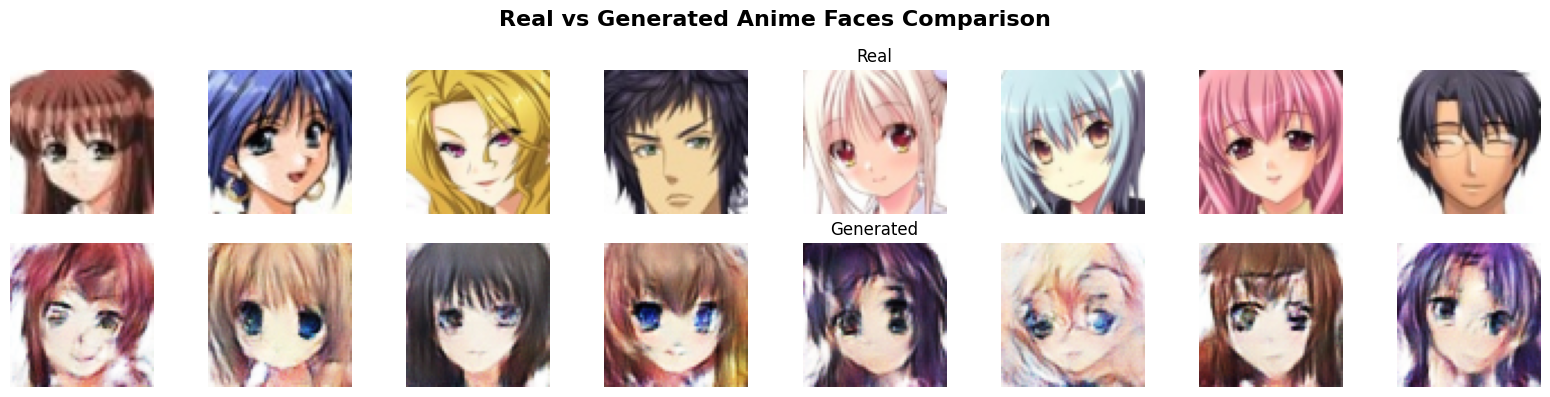

In [30]:
# Perform comparison
compare_real_vs_generated(train_dataloader, generator)

## Save Model and Generate Additional Samples

Finally, let's save our trained generator model and create a larger collection of generated anime faces to showcase our results.


In [31]:
# Save the generator model state_dict
torch.save(generator.state_dict(), 'anime_face_generator_pytorch.pth')
print("Generator model saved as 'anime_face_generator_pytorch.pth'")

Generator model saved as 'anime_face_generator_pytorch.pth'


# Conclusion and Next Steps

### What We Accomplished:
- Successfully implemented a GAN for anime face generation
- Processed 63,632 anime face images
- Trained both Generator and Discriminator networks
- Generated realistic anime faces from random noise
- Visualized training progress and final results

### Key Observations:
1. **Training Stability**: Monitor loss curves to ensure balanced training
2. **Image Quality**: Generated faces show clear anime characteristics
3. **Diversity**: Model produces varied faces with different styles and features
4. **Training Time**: ~{EPOCHS} epochs provided good results

In [32]:
print(f'Final Generator Loss: {gen_losses[-1]:.4f}')
print(f'Final Discriminator Loss: {disc_losses[-1]:.4f}')
print(f'Training Dataset Size: {dataset_size:,} images')

Final Generator Loss: 1.2817
Final Discriminator Loss: 1.0738
Training Dataset Size: 63,565 images


### Potential Improvements:
1. **Higher Resolution**: Train with 128x128 or 256x256 images
2. **Progressive Growing**: Implement progressive GAN architecture
3. **Style Transfer**: Add conditional generation for specific anime styles
4. **Advanced Architectures**: Try StyleGAN or WGAN-GP
5. **Data Augmentation**: Add more sophisticated augmentation techniques

Generating a collection of anime faces (PyTorch)...


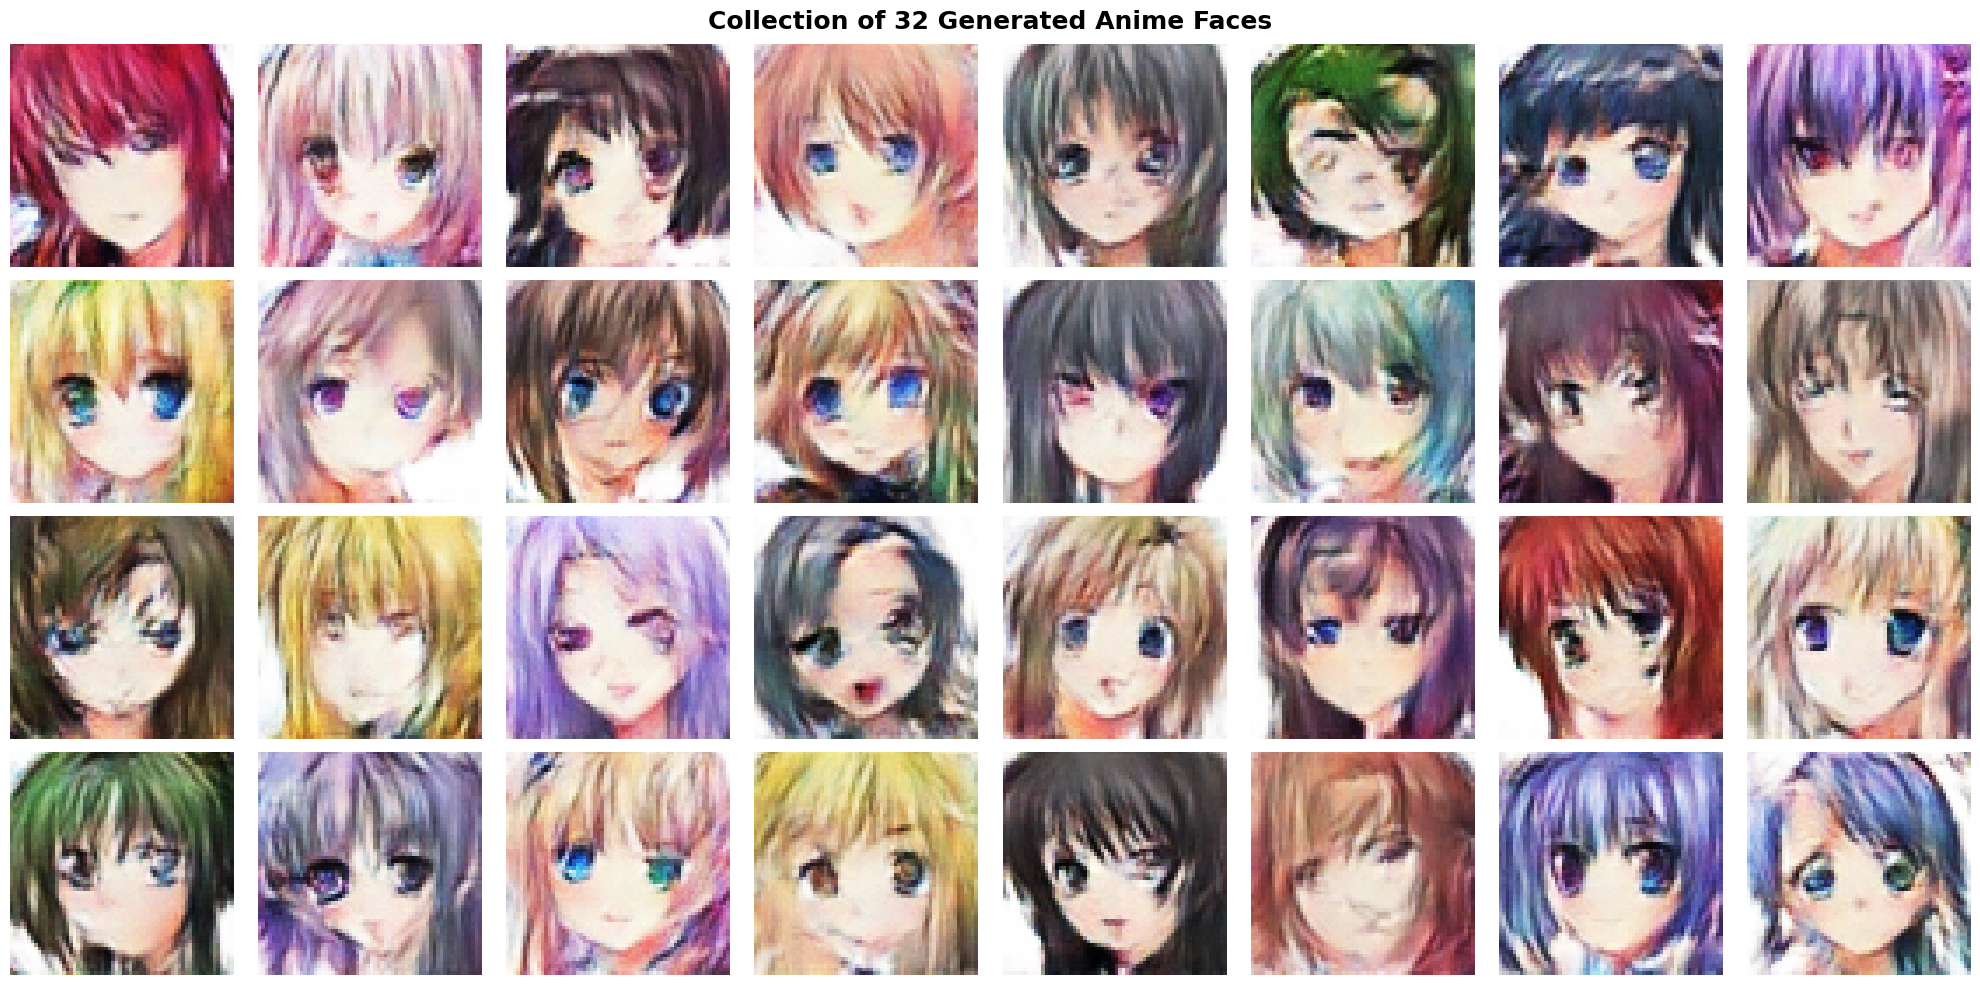

In [33]:
# Generate a large batch of samples
print("Generating a collection of anime faces (PyTorch)...")

num_samples = 32
large_noise = torch.randn(num_samples, NOISE_DIM, device=device)

generator.eval() 
with torch.no_grad(): 
    large_generated_batch = generator(large_noise).cpu()
generator.train() 

# Display the large collection
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle(f'Collection of {num_samples} Generated Anime Faces', fontsize=18, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        # Denormalize from [-1, 1] to [0, 1]
        img = large_generated_batch[i] * 0.5 + 0.5
        img = torch.clamp(img, 0.0, 1.0) # Clip values
        ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis('off')

plt.tight_layout()
plt.show()

## Additional Utility Functions

Here are some bonus utility functions we can use to further explore our trained GAN:

In [34]:
def interpolate_between_faces(model_G, face1_noise, face2_noise, steps=10): 
    """Create smooth interpolation between two generated faces using PyTorch."""
    interpolated_faces_tensors = [] 
    
    model_G.eval() 
    with torch.no_grad(): 
        for i in range(steps):
            alpha = i / (steps - 1)
            interpolated_noise = (1 - alpha) * face1_noise + alpha * face2_noise
            face_tensor = model_G(interpolated_noise).cpu()
            interpolated_faces_tensors.append(face_tensor[0]) 
    model_G.train() 
    
    # Display interpolation
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    fig.suptitle('Face Interpolation (PyTorch)', fontsize=14, fontweight='bold')
    
    for i, ax in enumerate(axes):
        # Denormalize from [-1, 1] to [0, 1]
        img = interpolated_faces_tensors[i] * 0.5 + 0.5
        img = torch.clamp(img, 0.0, 1.0) # Clip values
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(f'Step {i+1}')
    
    plt.tight_layout()
    plt.show()

In [35]:
def generate_face_grid(model_G, rows=8, cols=8):
    """Generate a large grid of faces using PyTorch."""
    total_faces = rows * cols
    noise = torch.randn(total_faces, NOISE_DIM, device=device)
    
    model_G.eval() 
    with torch.no_grad(): 
        faces_tensors = model_G(noise).cpu()
    model_G.train()
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    fig.suptitle(f'{total_faces} Generated Anime Faces (PyTorch)', fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        if i < total_faces:
            # Denormalize from [-1, 1] to [0, 1]
            img = faces_tensors[i] * 0.5 + 0.5
            img = torch.clamp(img, 0.0, 1.0) # Clip values
            ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [36]:
def analyze_generated_diversity(model_G, num_samples=100): #
    """Analyze the diversity of generated samples using PyTorch."""
    noise = torch.randn(num_samples, NOISE_DIM, device=device)
    
    model_G.eval() 
    with torch.no_grad():
        generated_faces_tensors = model_G(noise).cpu()
    model_G.train() 
    
    faces_np = generated_faces_tensors.numpy() * 0.5 + 0.5
    faces_np = np.clip(faces_np, 0.0, 1.0) # Clip after denormalization

    mean_pixel_values = np.mean(faces_np, axis=(1, 2, 3)) # N, C, H, W - mean over C, H, W
    std_pixel_values = np.std(faces_np, axis=(1, 2, 3))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
    
    axes[0].hist(mean_pixel_values, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of Mean Pixel Values')
    axes[0].set_xlabel('Mean Pixel Value')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(std_pixel_values, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Distribution of Pixel Standard Deviations')
    axes[1].set_xlabel('Pixel Standard Deviation')
    axes[1].set_ylabel('Frequency')
    
    plt.suptitle('Generated Samples Diversity Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Diversity Analysis Results (PyTorch):")
    print(f"Mean pixel value range: {np.min(mean_pixel_values):.3f} - {np.max(mean_pixel_values):.3f}")
    print(f"Std pixel value range: {np.min(std_pixel_values):.3f} - {np.max(std_pixel_values):.3f}")
    print(f"Overall diversity score: {np.std(mean_pixel_values):.3f}")


Running utility functions (PyTorch)...


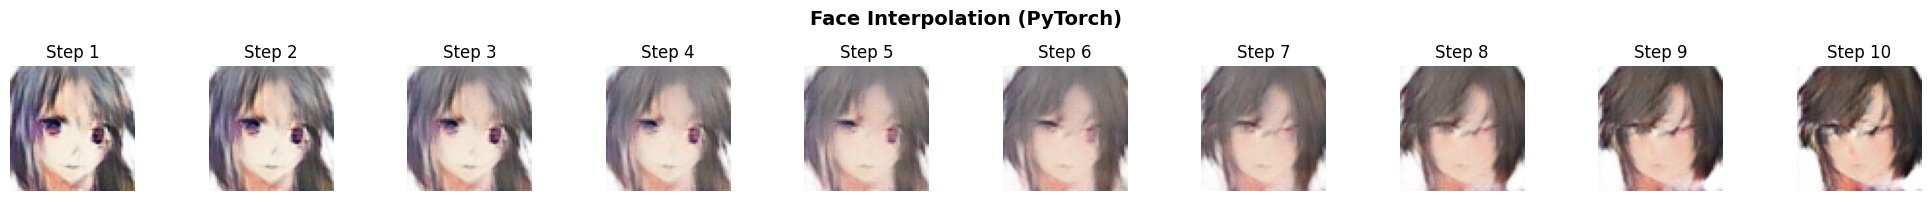

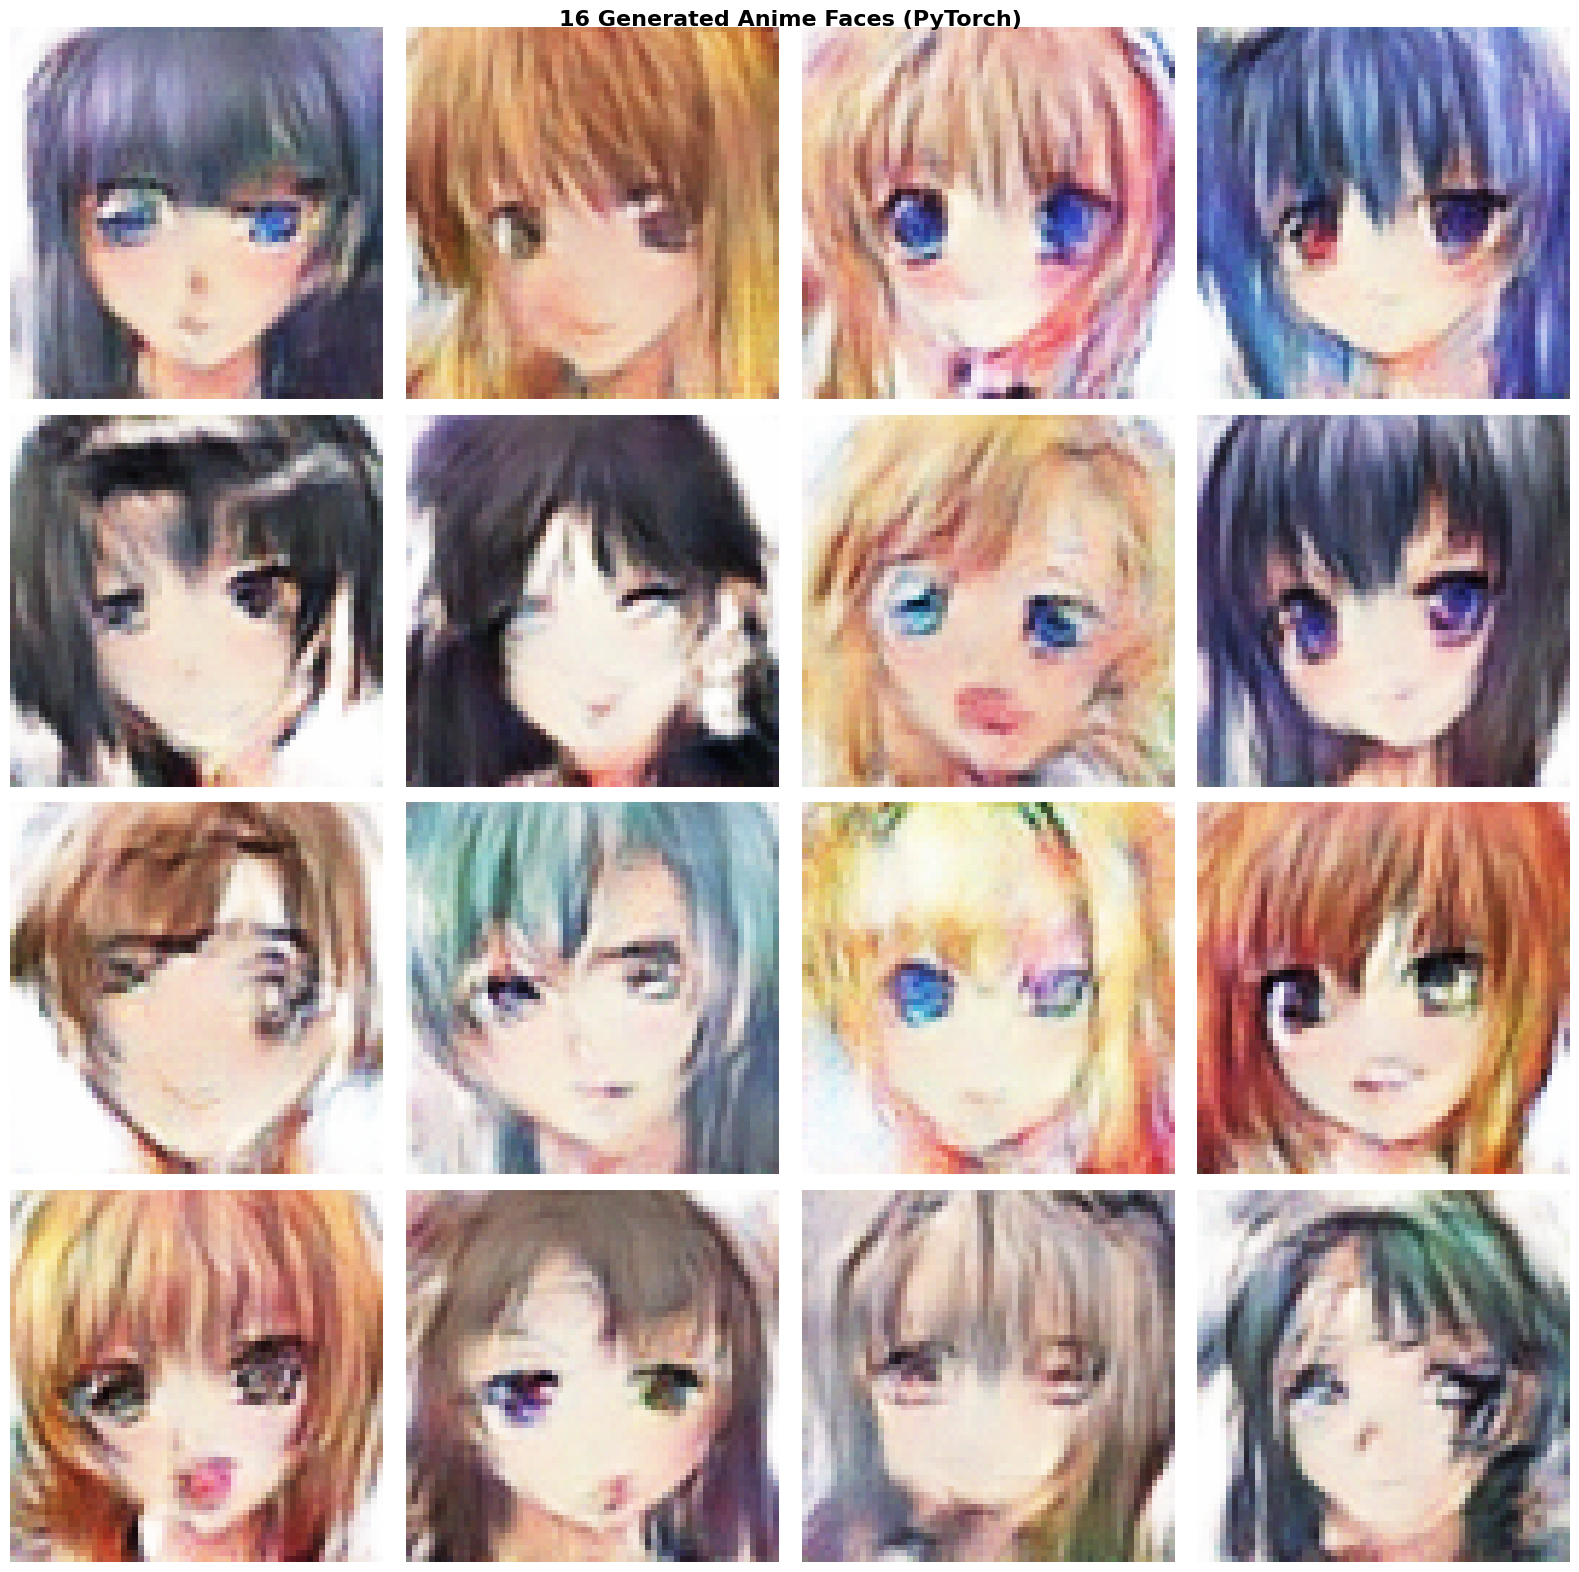

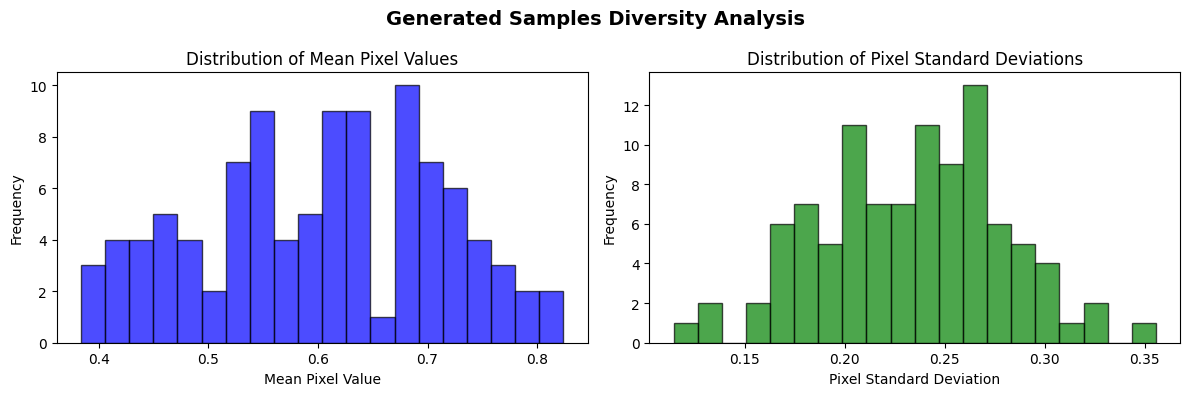

Diversity Analysis Results (PyTorch):
Mean pixel value range: 0.384 - 0.824
Std pixel value range: 0.114 - 0.356
Overall diversity score: 0.109


In [37]:
print("Running utility functions (PyTorch)...")

# Ensure noise tensors are created on the correct device for the model
noise1 = torch.randn(1, NOISE_DIM, device=device)
noise2 = torch.randn(1, NOISE_DIM, device=device)

interpolate_between_faces(generator, noise1, noise2)
generate_face_grid(generator, rows=4, cols=4) 
analyze_generated_diversity(generator)